# Apple Watch Health Data

This project is an exploration of the data collected by my Apple Watch over the course of about one year.

In [3]:
import pandas as pd
import seaborn as sns
from dateutil import parser
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()
import matplotlib.pyplot as plt
%matplotlib inline

# Parsing Apple Watch XML Data

The iOS Health app has as function that lets a user dump all of the data collected into an XML file. I wrote a Python library to parse this XML and export each category as a CSV.

**Note:** The cell below can take several minutes to run depending on the size of the XML file being parsed.

In [138]:
from lib.AppleWatchParser import AppleWatchParser

# Path to Apple Watch XML file
watch_xml = 'export.xml'

# Directory where .CSVs are dumped out to
csv_directory = '.'

# Data categories to parse. Will ignore any categories not defined here.
# NOTE: No other categories have been tested other than the ones below.
categories_to_parse = ['HKQuantityTypeIdentifierBodyMass', 'HKQuantityTypeIdentifierOxygenSaturation',
                        'HKQuantityTypeIdentifierDistanceWalkingRunning',
                        'HKQuantityTypeIdentifierAppleExerciseTime', 'HKQuantityTypeIdentifierDistanceCycling',
                        'HKQuantityTypeIdentifierRestingHeartRate',
                        'HKQuantityTypeIdentifierWalkingHeartRateAverage',
                        'HKQuantityTypeIdentifierAppleStandTime', 'HKQuantityTypeIdentifierHeartRateVariabilitySDNN',
                        'HKCategoryTypeIdentifierSleepAnalysis', 'HKQuantityTypeIdentifierActiveEnergyBurned', 
                        'HKQuantityTypeIdentifierHeartRateVariabilitySDNN']

# Create AppleWatchParser object
watch_data = AppleWatchParser(watch_xml, categories_to_parse)

# Write out watch data to CSV
watch_data.to_csv(csv_directory)

Available health categories:
['HKQuantityTypeIdentifierHeight', 'HKQuantityTypeIdentifierBodyMass', 'HKQuantityTypeIdentifierHeartRate', 'HKQuantityTypeIdentifierOxygenSaturation', 'HKQuantityTypeIdentifierStepCount', 'HKQuantityTypeIdentifierDistanceWalkingRunning', 'HKQuantityTypeIdentifierBasalEnergyBurned', 'HKQuantityTypeIdentifierActiveEnergyBurned', 'HKQuantityTypeIdentifierFlightsClimbed', 'HKQuantityTypeIdentifierDietaryFatTotal', 'HKQuantityTypeIdentifierDietaryFatSaturated', 'HKQuantityTypeIdentifierDietaryCholesterol', 'HKQuantityTypeIdentifierDietarySodium', 'HKQuantityTypeIdentifierDietaryCarbohydrates', 'HKQuantityTypeIdentifierDietaryFiber', 'HKQuantityTypeIdentifierDietarySugar', 'HKQuantityTypeIdentifierDietaryEnergyConsumed', 'HKQuantityTypeIdentifierDietaryProtein', 'HKQuantityTypeIdentifierAppleExerciseTime', 'HKQuantityTypeIdentifierDistanceCycling', 'HKQuantityTypeIdentifierRestingHeartRate', 'HKQuantityTypeIdentifierVO2Max', 'HKQuantityTypeIdentifierWalkingHeart

There will now be CSVs of each category requested in the current working directory.

# Resting Heartrate Data

In [86]:
# Resting HR from Apple Watch
resting_hr = pd.read_csv('HKQuantityTypeIdentifierRestingHeartRate.csv', parse_dates=True, index_col='Date')

In [87]:
resting_hr.head()

,Value,Unit
Date,,
2020-10-13 22:40:41-07:00,65,count/min
2020-10-14 21:19:02-07:00,63,count/min
2020-10-15 18:58:04-07:00,64,count/min
2020-10-16 22:41:50-07:00,55,count/min
2020-10-17 21:10:58-07:00,55,count/min


In [88]:
hr_mean = resting_hr['Value'].mean(axis=0)

In [89]:
resting_hr.iplot(y='Value', yTitle='Resting HR')

In [90]:
# There should only be 324 entries, so there are duplicates
resting_hr = resting_hr.resample('D').sum()

# 71 is the highest value, so any values above that will be duplicated for that particular day
# all of these are duplicate entires, so replace these with the average resting HR
resting_hr['Value'] = resting_hr['Value'].apply(lambda x: hr_mean if x > 71.0 else x)
resting_hr.loc[resting_hr['Value'] == 0.0] = hr_mean 


# Heartrate Variability Data

In [91]:
hrv = pd.read_csv('HKQuantityTypeIdentifierHeartRateVariabilitySDNN.csv', parse_dates=True, index_col='Date')
hrv.iplot(yTitle='HRV (ms)')

These data are very noisy and there are multiple readings per day. Let's take the average HRV over each day.

In [92]:
hrv = hrv.resample('D').mean()
#hrv.iplot(yTitle='HRV (ms)')

In [93]:
# There are some days where data are missing. Fill in these datapoints with the average
hrv_mean = hrv['Value'].mean(axis=0)
hrv['Value'] = hrv['Value'].apply(lambda x: hrv_mean if pd.isna(x) else x)
hrv.iplot(yTitle='HRV (ms)')

# Weather Data

In [94]:
# Weather https://www.ncdc.noaa.gov/cdo-web/
weather = pd.read_csv('2700509.csv', parse_dates=True, index_col='DATE')
weather.head()
weather = weather[['TMAX']]
#weather['DATE'] = pd.to_datetime(weather['DATE'])

In [95]:
weather.iplot(y='TMAX', yTitle='Maximum temperature (\u00B0F)')

# Strava Data

In [96]:
distance = pd.read_csv('HKQuantityTypeIdentifierDistanceWalkingRunning.csv', parse_dates=True, index_col='Date')

In [97]:
# Convert datetime strings to datetime objects
distance.head()

# Because the Apple Watch records small intervals of activity over the course of a day, the pandas resample method can be used to get a sum of distance walked/ran over each day
dist2 = distance.resample('D').sum()
dist2.iplot(yTitle='Distance walk+run (mi)')
# There's something wrong with this plot. The longest distance I've run is a half marathon, but according to this graph, I've walked/run more than one.
# Let's see what's going on with the data.

In [98]:
# Let's look at January 3, 2021
mask = (distance.index >= '2021-01-03') & (distance.index < '2021-01-04')
df = distance.loc[mask]

df[df['Value'] > 1.0]

# It looks like when you record an activity with another app, the Apple Watch dumps it all at once.
# It's possible that the Health app double counts Strava data.
#distance[distance['Value'] >= 1.0].iplot()

,Value,Unit
Date,,
2021-01-03 18:04:34-07:00,7.0256,mi


In [99]:
distance[distance['Value'] > 1.0].iplot(y='Value', yTitle='Distance walk+run (mi)')
# The numbers still aren't adding up. Luckily, I have consistently tracked my workouts with Strava, so I'll use that data instead.

In [106]:
# Some activities were manually added to this spreadsheet
strava = pd.read_csv('activities.csv', parse_dates=True, index_col='Activity Date')

In [107]:
strava.head()

,Activity ID,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Relative Effort,Commute,Activity Gear,Filename,...,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>"
Activity Date,,,,,,,,,,,,,,,,,,,,,
2017-03-21 23:20:20,9.094840e+08,Afternoon Ride,Ride,NaN,756.0,3.97,NaN,False,NaN,activities/909484019.gpx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-08 22:31:55,9.337941e+08,Afternoon Ride,Ride,NaN,2277.0,13.02,NaN,False,NaN,activities/933794093.gpx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-15 20:33:59,9.440155e+08,Afternoon Ride,Ride,NaN,8134.0,49.33,NaN,False,NaN,activities/944015496.gpx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-10 19:47:51,1.226077e+09,Lunch Ride,Ride,NaN,1740.0,0.63,NaN,False,NaN,activities/1226076972.gpx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-11 19:32:55,1.226078e+09,Yosemite,Ride,NaN,15329.0,12.53,NaN,False,NaN,activities/1226077715.gpx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
# I want a few statistics that might be related to metrics that the Apple Watch tracks, like sleep time or resting heartrate.
strava = strava[['Relative Effort', 'Distance', 'Elevation Gain']]

In [109]:
# Filter out any data from before the Apple Watch data (October 13, 2020)
strava = strava.loc[strava.index >= '2020-10-13']

In [110]:
# Strava's data is in SI units. Convert to Imperial units. 
strava['Distance'] = strava['Distance'] / 1.60934  # km to mi
strava['Elevation Gain'] = strava['Elevation Gain'] * 3.28084  # m to ft

# It's possible to have multiple activities per day. This should be a pretty rare occurrance
strava = strava.resample('D').sum()

In [111]:
strava.iplot(y='Distance', yTitle='Distance (mi)')

In [112]:
strava.iplot(y='Elevation Gain', yTitle='Elevation Gain (ft)')

In [113]:
strava.iplot(y='Relative Effort', yTitle='Relative Effort')

# Sleep data

In [114]:
# Sleep
# Apple Watch tends to greatly overestimate the amount of sleep I get. If I'm reading in bed, it usually counts that as sleep.
# I use an app called AutoSleep instead--it's fairly accurate. I've only been using it since December 2020, so I'll have to make an educated guess to fill in October 2020-November 2020
sleep = pd.read_csv('AutoSleep.csv', parse_dates=True, index_col='toDate')
sleep = sleep[['asleep']]

# Need to convert the "asleep" column from hh:mm:ss to decimal hours
def to_hours(t):
    temp = t.split(':')
    
    # convert to hours
    hours = float(temp[0])
    minutes = float(temp[1]) / 60.0
    seconds = float(temp[2]) / 3600.0
    
    return hours + minutes + seconds

sleep.head()


,asleep
toDate,
2020-12-06,7:57:00
2020-12-07,7:37:00
2020-12-08,9:02:00
2020-12-09,8:39:00
2020-12-10,8:39:00


In [115]:
sleep['asleep'] = sleep['asleep'].apply(to_hours)
sleep.iplot(y='asleep', yTitle='Time asleep (hours)')

In [116]:
sleep_mean = sleep['asleep'].mean(axis=0)

In [117]:
# I'll fill in the missing data by taking the average of the sleep data I have starting on December 6, 2020.
dates = pd.date_range(start='10/13/2020', end='12/5/2020', freq='D')
time_asleep = [sleep_mean] * len(dates)
pd.DataFrame(index=dates, data=time_asleep, columns=['asleep'])
sleep = pd.concat([pd.DataFrame(index=dates, data=time_asleep, columns=['asleep']), sleep])

In [118]:
sleep.iplot(y='asleep', yTitle='Time asleep (hours)')

In [119]:
# There should be 323 entires, one for each day. Resample and sum so any missing time series rows are now 0
# Any 0's are from when I didn't wear the watch to bed. Replace them with the mean time asleep, 7.95 hours.
sleep = sleep.resample('D').sum()
sleep.loc[sleep['asleep'] == 0.0] = sleep_mean

# Stand Time

In [121]:
stand_time = pd.read_csv('HKQuantityTypeIdentifierAppleStandTime.csv', parse_dates=True, index_col='Date')
stand_time = stand_time.resample('D').sum() / 60.0
stand_time.iplot(yTitle='Standing time (hours)')

# Putting It All Together

In [122]:
# Change indices to naive timestamps and concatenate
df = pd.concat([weather.tz_localize(None),
                resting_hr.tz_localize(None),
                sleep.tz_localize(None),
                strava.tz_localize(None),
                stand_time.tz_localize(None),
                hrv.tz_localize(None)], axis=1)

In [123]:
# Check for any missing data
df.isnull().values.any()

False

In [124]:
df.head()

,TMAX,Value,asleep,Relative Effort,Distance,Elevation Gain,Stand time,Value
2020-10-13,65,65.0,8.017688,0.0,3.150008,0.0,0.266667,69.049700
2020-10-14,62,63.0,8.017688,0.0,0.000000,0.0,0.300000,89.921669
2020-10-15,63,64.0,8.017688,0.0,0.000000,0.0,1.250000,65.280938
2020-10-16,70,55.0,8.017688,0.0,7.140000,0.0,1.650000,68.416408
2020-10-17,69,55.0,8.017688,0.0,0.000000,0.0,0.466667,75.142207


In [125]:
# Rename columns to something more descriptive
df.columns=['Temperature High (\u00B0F)',
            'Resting HR (BPM)', 
            'Time Asleep (hours)', 
            'Relative Effort', 
            'Distance (mi)', 
            'Elevation Gain (ft)',
            'Stand time (hours)', 
            'HRV (ms)']
df.head()

,Temperature High (°F),Resting HR (BPM),Time Asleep (hours),Relative Effort,Distance (mi),Elevation Gain (ft),Stand time (hours),HRV (ms)
2020-10-13,65,65.0,8.017688,0.0,3.150008,0.0,0.266667,69.049700
2020-10-14,62,63.0,8.017688,0.0,0.000000,0.0,0.300000,89.921669
2020-10-15,63,64.0,8.017688,0.0,0.000000,0.0,1.250000,65.280938
2020-10-16,70,55.0,8.017688,0.0,7.140000,0.0,1.650000,68.416408
2020-10-17,69,55.0,8.017688,0.0,0.000000,0.0,0.466667,75.142207


<AxesSubplot:>

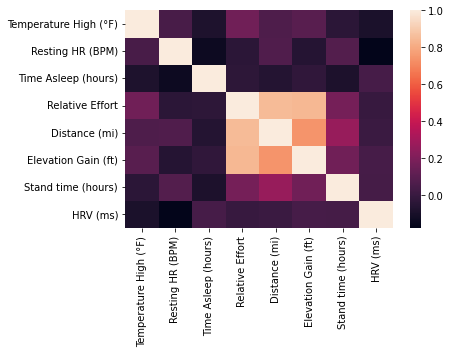

In [126]:
sns.heatmap(df.corr())

# Linear Regression

In [127]:
# Try and predict Relative Effort parameter based on:
X = df[['Temperature High (\u00B0F)', 'Resting HR (BPM)', 'Time Asleep (hours)', 'Distance (mi)', 
            'Elevation Gain (ft)',
            'Stand time (hours)', 
            'HRV (ms)']]
y = df['Relative Effort']

In [128]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=15)

In [129]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [130]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Temperature High (°F),0.617834
Resting HR (BPM),-0.827328
Time Asleep (hours),0.336092
Distance (mi),14.359536
Elevation Gain (ft),0.075301
Stand time (hours),-7.469690
HRV (ms),-0.093893


Analysis goes here.

# Predictions

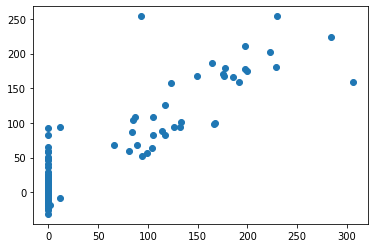

In [136]:
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions)

There are a lot of zeros in the validation data. Barring those values, there is potentially a weak correlation here. More data would be useful.

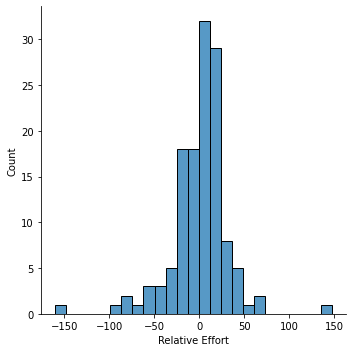

In [137]:
sns.displot((y_test-predictions),bins=25);

Again, there are not a lot of data points. As sample size gets larger, this plot looks like it would approach a Gaussian distribution.

# Conclusions

First, the Relative Effort Parameter from Strava is likely calculated based on

In [ ]:
git